In [25]:
# Bibliotecas
import sys, pandas as pd, numpy as np
import plotly.express as px
import seaborn as sns, numpy as np, os
from os.path import exists
sys.path.append('../')

from env.RiverProblem import RiverProblem
from rl_utils.VizTools import VizTools

# Modelos
from models.ValueIteration import ValueIteration
from models.PolicyIteration import PolicyIteration
from models.RS_PolicyIteration import RS_PolicyIteration
from models.PieceLinear_RSPI import PieceLinear_RSPI
from models.PieceLinear_RSVI import PieceLinear_RSVI

from evaluation.AverageCosts import AverageCosts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experimentos - 1S2023

|Data|Descritivo|
|--|--|
|03-2023|Primeiros experimentos com confecção de artigo|

---

## Referências

**Exponential**

2013 MICAI: Shortest Stochastic Path with Risk Sensitive Evaluation \
ou 2016 BRACIS: Extreme Risk Averse Policy for Goal-Directed Risk-Sensitive MDP

**Piecewise Linear**

2020 MICAI: Risk-Sensitive Piecewise-Linear Policy Iteration for SSP-MDP

In [26]:
# ----------------------------------------------
# -- Configurações Iniciais --------------------
# ----------------------------------------------

run_value_iteration = False
run_policy_iteration = False
run_EUF_RSPI = True
run_PWL_RSPI = True
run_PWL_RSVI = True

# -- Configurações Rio

grid_size = (5, 20)
goal_state = (4, 0)

rp = RiverProblem(grid_size, goal_state, dead_end=False)
block_type = rp.build_block_type()

In [27]:
def run_river_problem(river_flow, model_obj, epsilon=None, vl_lambda=None, discount_factor=None, 
                                     k=None, gamma=None, alpha=None, _log=False):
    transition_probabilities = rp.build_transition_probabilities(block_type, river_flow=river_flow)

    is_ok, dict_verification = rp._verify_sum_probabilities(transition_probabilities, block_type)
    if not is_ok: print(f'Soma das Probabilidades está válida? {is_ok}')
    
    if epsilon != None and discount_factor != None:
        rnp = model_obj(grid_size, goal_state, transition_probabilities, costs, 
                         num_actions=4, discount_factor=discount_factor, epsilon=epsilon, river_flow=river_flow)
    elif epsilon != None and vl_lambda != None:
        rnp = model_obj(grid_size, goal_state, transition_probabilities, costs, vl_lambda,
                         num_actions=4, epsilon=epsilon, river_flow=river_flow)
    elif epsilon != None and k != None and gamma != None and alpha != None:
        rnp = model_obj(grid_size, goal_state, transition_probabilities, costs, k, alpha, gamma,
                         num_actions=4, epsilon=epsilon, river_flow=river_flow)
    
    num_iterations, time = rnp.run_converge()
    if _log: print(f'Número de Iterações: {num_iterations}')
    if _log: print(f'Tempo de Execução: {time}s')
    
    return rnp

# Value Iteration

In [4]:
# Value Iteration - Configs
if run_value_iteration:
    discount_factor = 0.95
    epsilon = 0.001

    costs = {0: 1, 1: 1, 2: 1, 3: 1}
    block_type = rp.build_block_type()

In [5]:
# Value Iteration - Run
if run_value_iteration:
    value_iteration_01 = \
    run_river_problem(river_flow=0.1, model_obj=ValueIteration, epsilon=epsilon, discount_factor=discount_factor)
    value_iteration_05 = \
    run_river_problem(river_flow=0.75, model_obj=ValueIteration, epsilon=epsilon, discount_factor=discount_factor)
    value_iteration_09 = \
    run_river_problem(river_flow=0.9, model_obj=ValueIteration, epsilon=epsilon, discount_factor=discount_factor)

In [6]:
# Value Iteration - Displays
if run_value_iteration:
    display(value_iteration_01)
    display(value_iteration_05)
    display(value_iteration_09)

# Policy Iteration

Definimos o algoritmo de Policy Iteration da seguinte forma:

1. Escolhe uma política $\pi_0$ arbitrária;
2. Define $i=0$ como a quantidade de iterações;
3. Para cada iteração, enquanto ($i=0$ ou $\pi_i \neq \pi_{i-1}$) faça: \
    3.1. Policy Evaluation: obtém o valor da política atual $\pi_i$ para cada $s \in S$ resolvendo o seguinte sistema de equações: \
    $$V^{(\pi_i)}(s)=r(s,\pi_i(s))+\sum_{s'\in S} T(s, \pi_i(s), s') V^{\pi_i}(s') \forall s \in S$$
    3.2. Policy Improvement: melhora a política atual realizando uma atualização para todo $s \in S$: \
    $$\pi_{i+1}(s)=\text{argmax}_{a \in A_s}[r(s,a)+\sum_{s'\in S} T(s, a, s') V^{\pi_i}(s')]$$

In [7]:
# Policy Iteration - Configs
if run_policy_iteration:
    discount_factor = 0.99
    epsilon = 0.001
    costs = {0: 1, 1: 1, 2: 1, 3: 1}

In [8]:
# Policy Iteration - Run
if run_policy_iteration:
    policy_iteration_01 = \
    run_river_problem(river_flow=0.1, model_obj=PolicyIteration, epsilon=epsilon, discount_factor=discount_factor)
    policy_iteration_05 = \
    run_river_problem(river_flow=0.5, model_obj=PolicyIteration, epsilon=epsilon, discount_factor=discount_factor)
    policy_iteration_09 = \
    run_river_problem(river_flow=0.9, model_obj=PolicyIteration, epsilon=epsilon, discount_factor=discount_factor)

In [9]:
# Policy Iteration - Displays
if run_policy_iteration:
    display(policy_iteration_01)
    display(policy_iteration_05)
    display(policy_iteration_09)

# Exponential Utility Function for RS-MDP

Definimos o algoritmo de Risk Sensitive MDP da seguinte forma:

1. Escolhe uma política $\pi_0$ arbitrária;
2. Define $i=0$ como a quantidade de iterações;
3. Para cada iteração, enquanto ($i=0$ ou $\pi_i \neq \pi_{i-1}$) faça: \
    3.1. Policy Evaluation: obtém o valor da política atual $\pi_i$ para cada $s \in S$ resolvendo o seguinte sistema de equações: \
    $$V^{\pi_i}(s_G)=-\text{sign}(\lambda)$$
    $$V^{(\pi_i)}(s)=\text{exp}(-\lambda r(s,\pi_i(s)))\sum_{s'\in S} T(s, \pi_i(s), s') V^{\pi_i}(s') \forall s \neq s_G \in S$$
    3.2. Policy Improvement: melhora a política atual realizando uma atualização para todo $s \in S$: \
    $$\pi_{i+1}(s)=\text{argmax}_{a \in A_s}[\text{exp}(-\lambda r(s,a))\sum_{s'\in S} T(s, a, s') V^{\pi_i}(s')]$$
    
    
When λ < 0 (risk prone) and the policy π is proper, then π is also λ-feasible. However, this is not guaranteed for all policies when λ > 0 (risk averse). Given a GD-RSMDP, no result exists on how to determine the set of λ > 0 such that exists a λ-feasible policy.


In [10]:
# Exponential Utility Function for RSPI - Configs
if run_EUF_RSPI:
    EUF_RSPI = {}

    range_river_flow = [0.75]
    range_lambda     = [0.5, 0.25, 0.1, 0.05, 0, -0.05, -0.1, -0.25] 
    epsilon = 0.001
    
    costs = {0: 1, 1: 1, 2: 1, 3: 1}

In [11]:
# Exponential Utility Function for RS-MDP - Run
if run_EUF_RSPI:
    for river_flow in range_river_flow:
        for vl_lambda in range_lambda:
            EUF_RSPI[(river_flow, vl_lambda)] = \
                run_river_problem(river_flow=river_flow, model_obj=RS_PolicyIteration, 
                vl_lambda=vl_lambda, epsilon=epsilon)

..\models\RS_PolicyIteration.py:128: RuntimeWarning: overflow encountered in double_scalars
  bellman = np.exp(-self._lambda * self._reward_function(S, a)) * \


In [12]:
# Exponential Utility Function for RS-MDP - Keys
if run_EUF_RSPI:
    display(EUF_RSPI.keys())

dict_keys([(0.75, 0.5), (0.75, 0.25), (0.75, 0.1), (0.75, 0.05), (0.75, 0), (0.75, -0.05), (0.75, -0.1), (0.75, -0.25)])

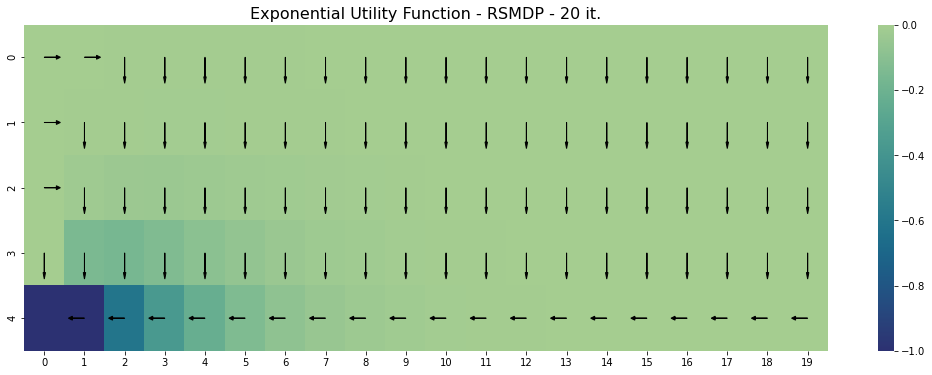

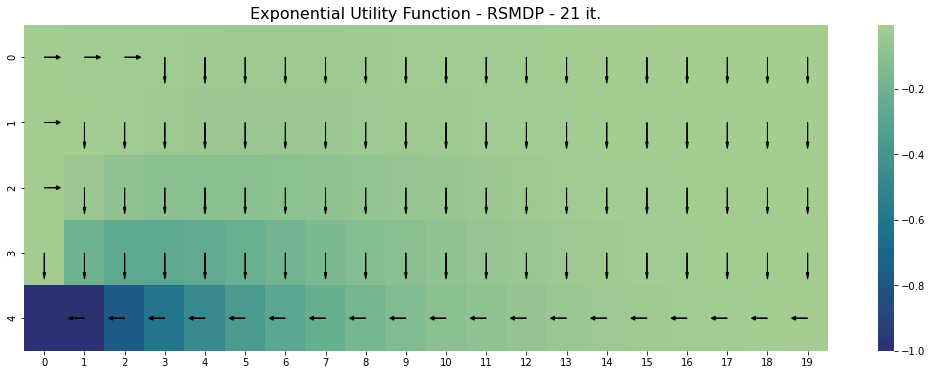

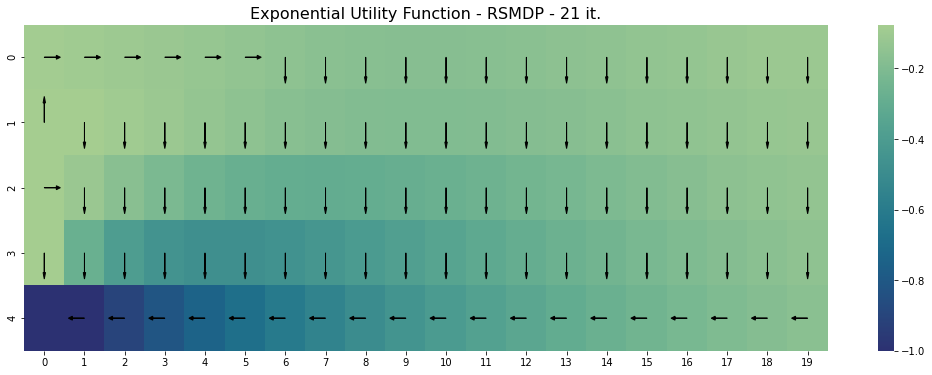

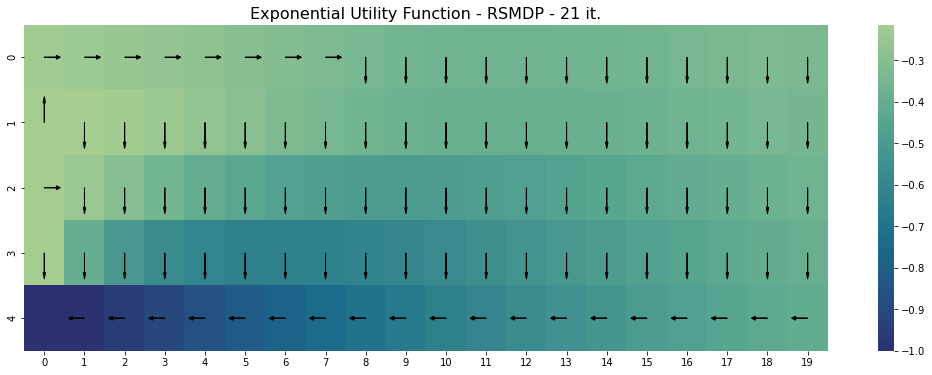

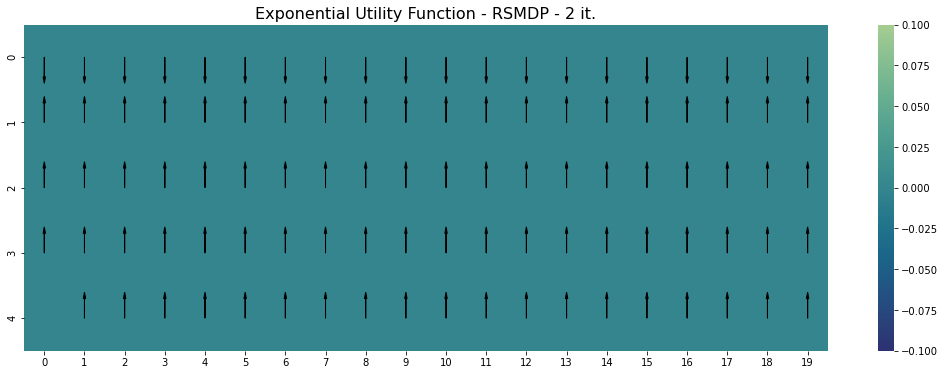

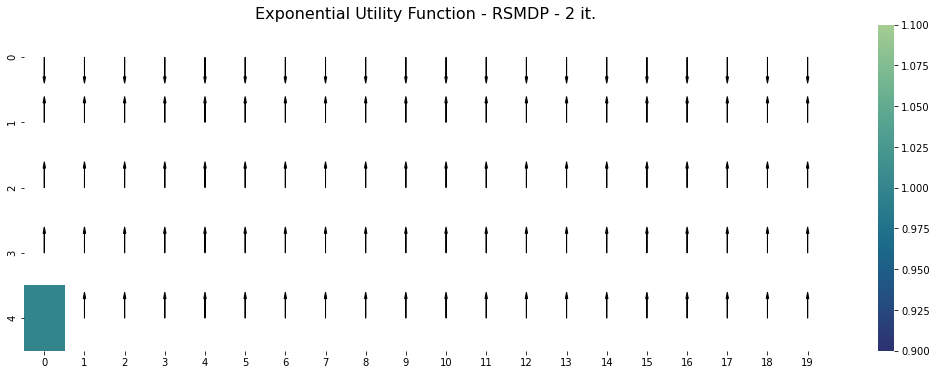

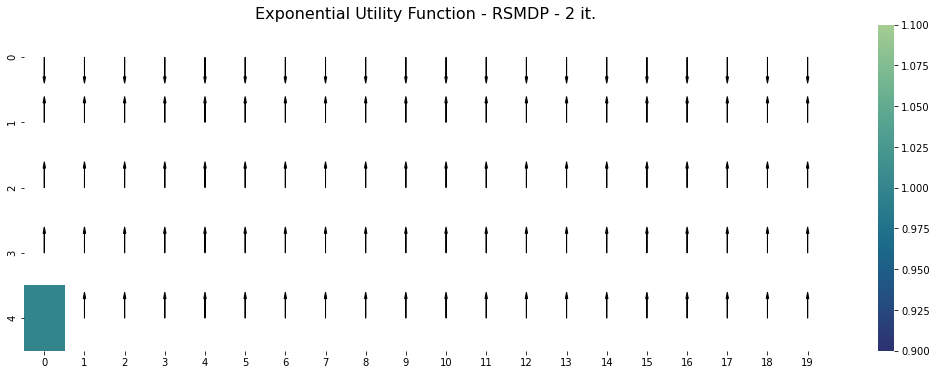

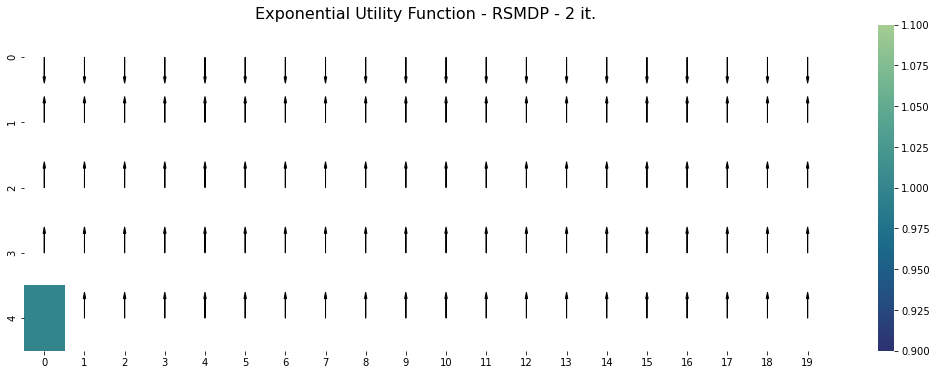

{(0.75,
  0.5): RiverProblem - 
 Lambda: 0.5 
 Epsilon: 0.001 ,
 (0.75,
  0.25): RiverProblem - 
 Lambda: 0.25 
 Epsilon: 0.001 ,
 (0.75,
  0.1): RiverProblem - 
 Lambda: 0.1 
 Epsilon: 0.001 ,
 (0.75,
  0.05): RiverProblem - 
 Lambda: 0.05 
 Epsilon: 0.001 ,
 (0.75,
  0): RiverProblem - 
 Lambda: 0 
 Epsilon: 0.001 ,
 (0.75,
  -0.05): RiverProblem - 
 Lambda: -0.05 
 Epsilon: 0.001 ,
 (0.75,
  -0.1): RiverProblem - 
 Lambda: -0.1 
 Epsilon: 0.001 ,
 (0.75,
  -0.25): RiverProblem - 
 Lambda: -0.25 
 Epsilon: 0.001 }

In [13]:
# Exponential Utility Function for RS-MDP - Display
if run_EUF_RSPI: 
    display(EUF_RSPI)
#     display(EUF_RSMDP[(0.2, 0)])

# PieceLinear - RSVI (Risk Sensitive Value Iteration)

Define-se uma transformação por partes linear $X^{(k)}$ que depende de um parâmetro $x$ (diferença temporal) seja positiva ou não e um fator de risco $k$:

$$X^{(k)}(x)= \left\{ \begin{array} & (1-k)x & \text{, if x < 0,} \\ (1+k)x & \text{, otherwise.} \end{array} \right. $$

---

In [46]:
# Piecewise-Linear RSPI - Configs
if run_PWL_RSVI:
    PWL_RSVI = {}
    
    range_river_flow = [0.2] #[rf/10 for rf in range(1, 10)]
    range_k     = [0] # [v/10 for v in range(-9, 10)]
    gamma       = 1
    range_alpha = [np.round(1/(1+abs(k)), 2) for k in range_k]
    epsilon = 0.005
    
    costs = {0: 1, 1: 1, 2: 1, 3: 1}

In [47]:
# Piecewise-Linear RSPI - Run
for river_flow in range_river_flow:
    for i in range(0, len(range_k)):
        print(f'Processando: RF [{river_flow}] K [{range_k[i]}] Alpha [{range_alpha[i]}]')
        PWL_RSVI[(river_flow, range_k[i], gamma, range_alpha[i])] = \
            run_river_problem(river_flow=river_flow, model_obj=PieceLinear_RSVI,
            gamma=gamma, k=range_k[i], alpha=range_alpha[i], epsilon=epsilon)

Processando: RF [0.2] K [0] Alpha [1.0]


In [48]:
PWL_RSVI.keys()

dict_keys([(0.2, 0, 1, 1.0)])

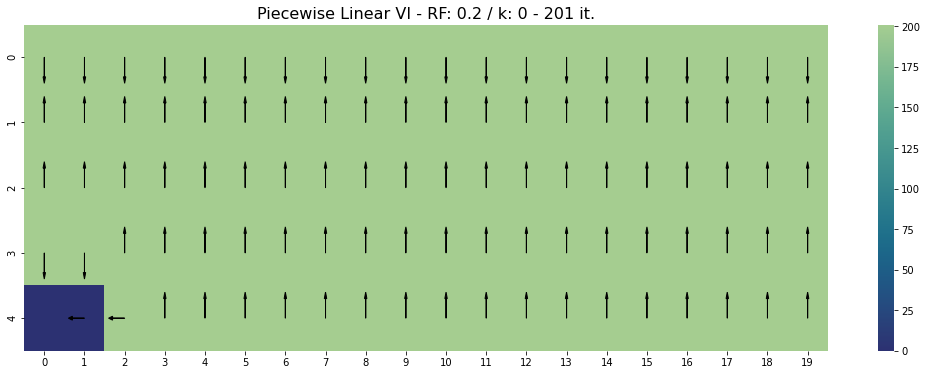

{(0.2,
  0,
  1,
  1.0): > Visualização da Política 
 k: 0 
 alpha: 1.0 
 gamma: 1 }

In [49]:
PWL_RSVI

# PieceLinear - RSPI (Risk Sensitive Policy Iteration)

Define-se uma transformação por partes linear $X^{(k)}$ que depende de um parâmetro $x$ (diferença temporal) seja positiva ou não e um fator de risco $k$:

$$X^{(k)}(x)= \left\{ \begin{array} & (1-k)x & \text{, if x < 0,} \\ (1+k)x & \text{, otherwise.} \end{array} \right. $$

1. Escolhe uma política $\pi_0$ arbitrária;
2. Define $i=0$ como a quantidade de iterações;
3. Para cada iteração, enquanto ($i=0$ ou $\pi_i \neq \pi_{i-1}$) faça: \
    3.1. Policy Evaluation: obtém o valor da política atual $\pi_i$ para cada $s \in S$ resolvendo o seguinte sistema de equações: \
    $$
    O^{\pi}_{\alpha k}[V](s) = V(s) + \alpha \sum_{s'\in S} P(s'|s, \pi(s)) X^{(k)}(C(s,\pi(s),s')+\gamma V(s') - V(s))    
    $$
    3.2. Policy Improvement: melhora a política atual realizando uma atualização para todo $s \in S$: \
    $$
    \pi'(s)=\text{argmin}_{a\in A}\sum_{s'\in S} P(s'|s, a) X^{(k)}(C(s,a,s')+\gamma V(s') - V^\pi_k(s))
    $$

In [14]:
# Piecewise-Linear RSPI - Configs
if run_PWL_RSPI:
    PWL_RSPI = {}
    
    range_river_flow = [0.75] #[rf/10 for rf in range(1, 10)]
    range_k     = [v/10 for v in range(-9, 10)]
    gamma       = 1
    range_alpha = [np.round(1/(1+abs(k)), 2) for k in range_k]
    epsilon = 0.005
    
    costs = {0: 1, 1: 1, 2: 1, 3: 1}

In [20]:
# Piecewise-Linear RSPI - Run
for river_flow in range_river_flow:
    for i in range(0, len(range_k)):
        print(f'Processando: RF [{river_flow}] K [{range_k[i]}] Alpha [{range_alpha[i]}]')
        PWL_RSPI[(river_flow, range_k[i], gamma, range_alpha[i])] = \
            run_river_problem(river_flow=river_flow, model_obj=PieceLinear_RSPI,
            gamma=gamma, k=range_k[i], alpha=range_alpha[i], epsilon=epsilon)

Processando: RF [0.75] K [-0.9] Alpha [0.53]
Processando: RF [0.75] K [-0.8] Alpha [0.56]
Processando: RF [0.75] K [-0.7] Alpha [0.59]
Processando: RF [0.75] K [-0.6] Alpha [0.62]
Processando: RF [0.75] K [-0.5] Alpha [0.67]
Processando: RF [0.75] K [-0.4] Alpha [0.71]
Iteração: 220

KeyboardInterrupt: 

In [21]:
PWL_RSPI.keys()

dict_keys([(0.75, -0.9, 1, 0.53), (0.75, -0.8, 1, 0.56), (0.75, -0.7, 1, 0.59), (0.75, -0.6, 1, 0.62), (0.75, -0.5, 1, 0.67), (0.75, -0.4, 1, 0.71), (0.75, -0.3, 1, 0.77), (0.75, -0.2, 1, 0.83), (0.75, -0.1, 1, 0.91), (0.75, 0.0, 1, 1.0)])

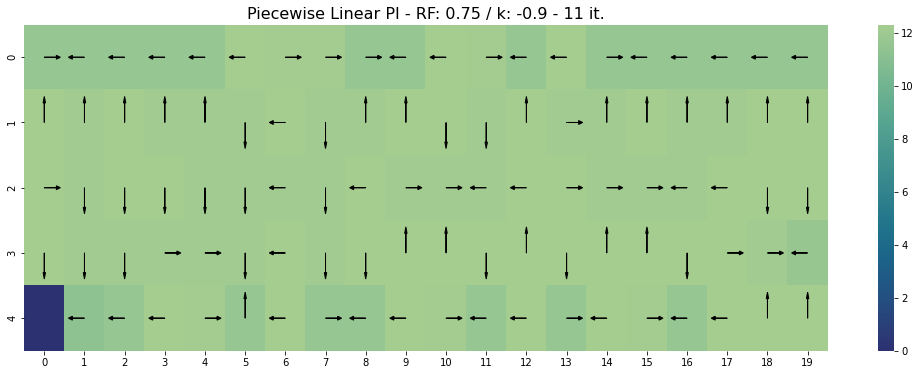

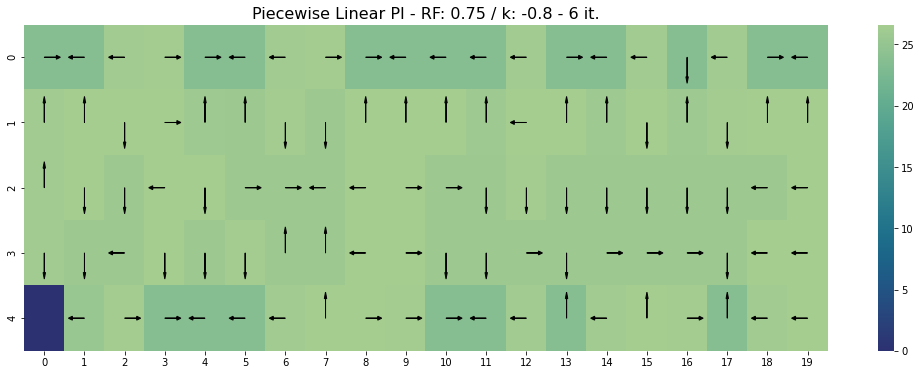

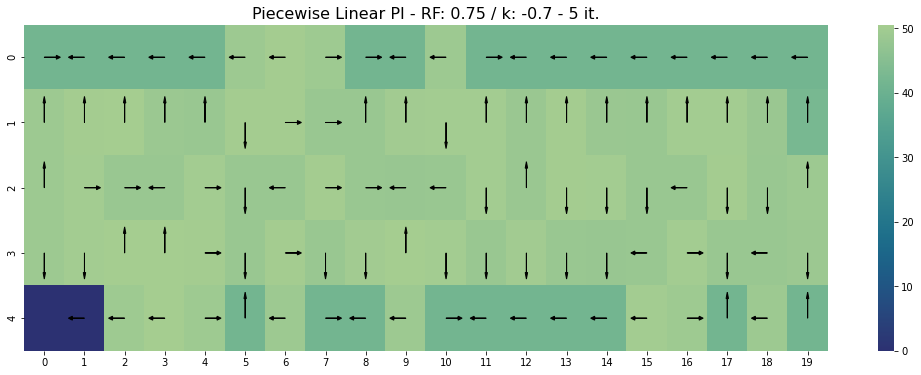

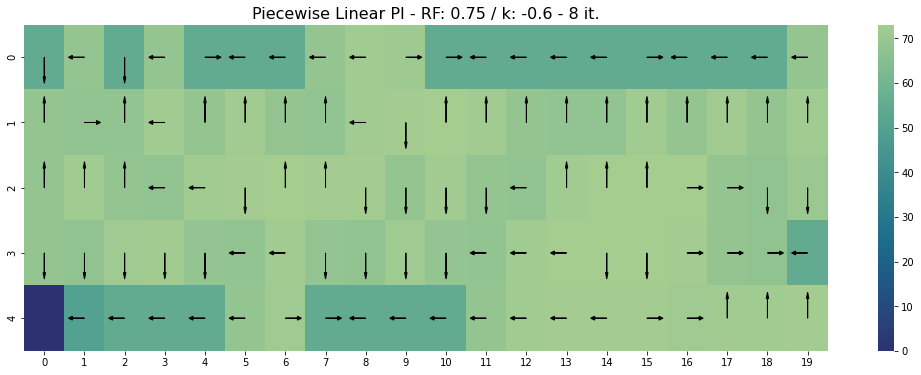

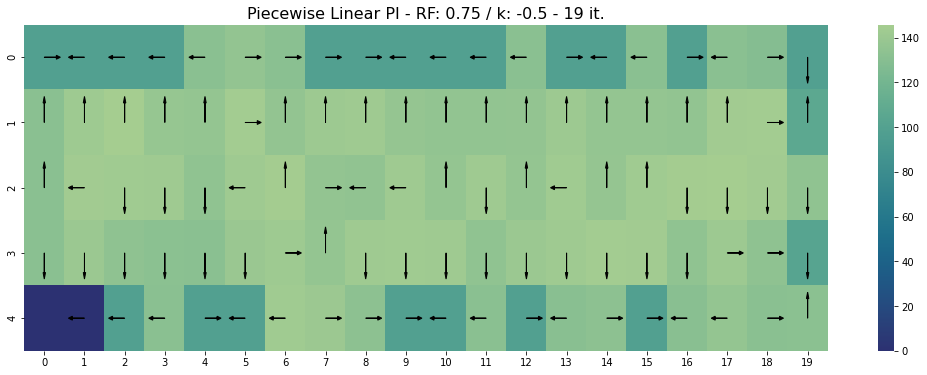

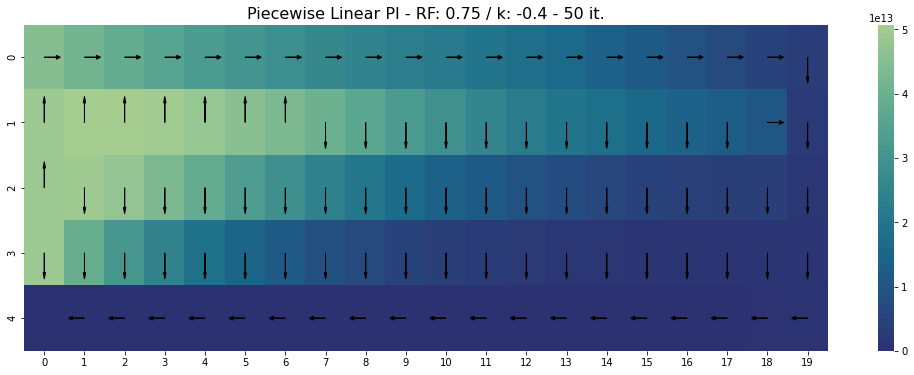

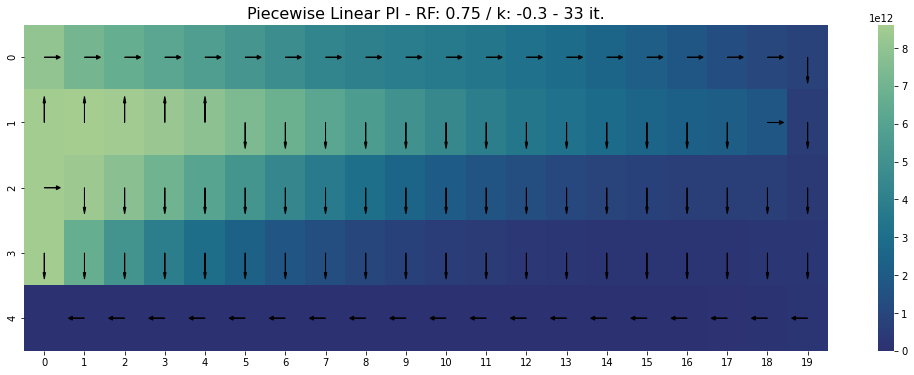

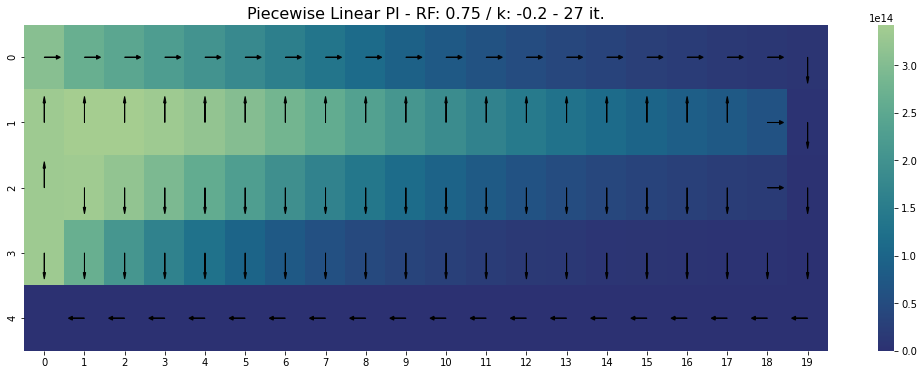

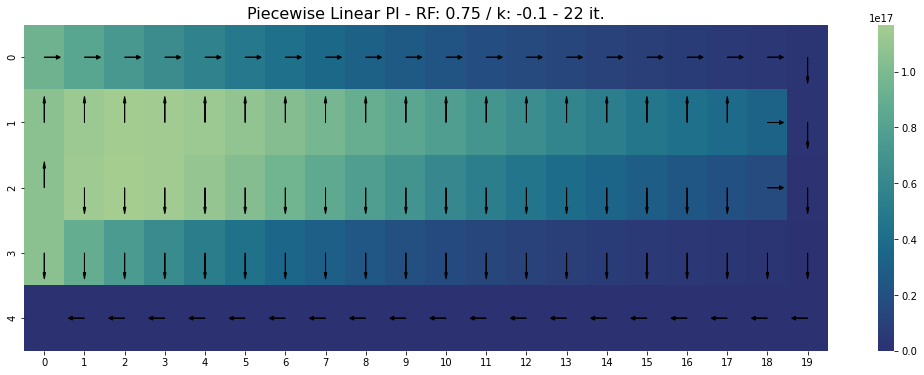

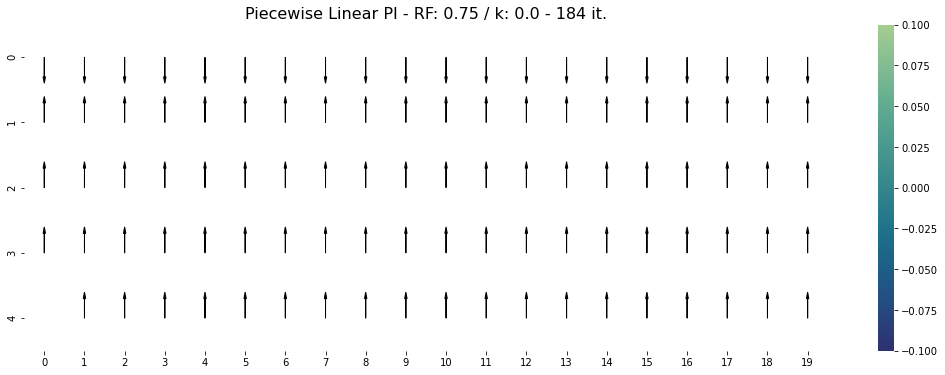

{(0.75,
  -0.9,
  1,
  0.53): > Visualização da Política 
 k: -0.9 
 alpha: 0.53 
 gamma: 1 ,
 (0.75,
  -0.8,
  1,
  0.56): > Visualização da Política 
 k: -0.8 
 alpha: 0.56 
 gamma: 1 ,
 (0.75,
  -0.7,
  1,
  0.59): > Visualização da Política 
 k: -0.7 
 alpha: 0.59 
 gamma: 1 ,
 (0.75,
  -0.6,
  1,
  0.62): > Visualização da Política 
 k: -0.6 
 alpha: 0.62 
 gamma: 1 ,
 (0.75,
  -0.5,
  1,
  0.67): > Visualização da Política 
 k: -0.5 
 alpha: 0.67 
 gamma: 1 ,
 (0.75,
  -0.4,
  1,
  0.71): > Visualização da Política 
 k: -0.4 
 alpha: 0.71 
 gamma: 1 ,
 (0.75,
  -0.3,
  1,
  0.77): > Visualização da Política 
 k: -0.3 
 alpha: 0.77 
 gamma: 1 ,
 (0.75,
  -0.2,
  1,
  0.83): > Visualização da Política 
 k: -0.2 
 alpha: 0.83 
 gamma: 1 ,
 (0.75,
  -0.1,
  1,
  0.91): > Visualização da Política 
 k: -0.1 
 alpha: 0.91 
 gamma: 1 ,
 (0.75,
  0.0,
  1,
  1.0): > Visualização da Política 
 k: 0.0 
 alpha: 1.0 
 gamma: 1 }

In [22]:
# PWL_RSPI[(0.2, -0.8, 1, 0.56)]
PWL_RSPI

# Comparando Políticas Geradas

* Fixar em um ambiente (0.2 por exemplo) que o neutro atravessa no meio do rio para observar mais facil os comportamentos;
* E para um só tamanho para validar o processo;
* Residual

Policy Evaluation Exponencial

1 - 
PEXP(env, lambda, pi) -> R, avaliação da política para este mundo com lambda/pi;

Gráfico: PEXP(env, lambda, pi_lambda) por lambda
         PEXP(env, lambda, pi_linear) por lambda

pi_linear = argmax_{pi_k} PEXP(env, lambda, pi_k)

2 - Contrário da (1)
P(env, K, pi) -> R, avaliação da política para este mundo com K/pi;

3 -
Lambda, K

k_max = argmax_{k} PEXP(env, lambda, pi_k)

4 - Contrário da (3)

lambda_max = argmax_{lambda} PLINEAR(env, k, pi_lambda)

---

_* Calcular a variancia de uma política através de programação dinâmica sem usar simulações_